# ME 5920 FINAL PROJECT - SCIENTIFIC SIMULATIONS GROUP 1



## Group Members



1.   Hossein Asgaribakhtiari
2.   George Ayobami Thomas
3.   Mridul Bhattarai




## 1.1) Setup and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Mounted at /content/drive


## 1.2) Load data from Google Drive (dataset 1)


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TRAIN_FD003.xlsx'
df = pd.read_excel(DATA_PATH)
print(df.head())

   Engine_ID  Cy_F    OP_1    OP_2  OP_3     S_1     S_2      S_3      S_4  \
0          1     1 -0.0005  0.0004   100  518.67  642.36  1583.23  1396.84   
1          1     2  0.0008 -0.0003   100  518.67  642.50  1584.69  1396.89   
2          1     3 -0.0014 -0.0002   100  518.67  642.18  1582.35  1405.61   
3          1     4 -0.0020  0.0001   100  518.67  642.92  1585.61  1392.27   
4          1     5  0.0016  0.0000   100  518.67  641.68  1588.63  1397.65   

     S_5  ...     S_14    S_15  S_16  S_17  S_18  S_19   S_20     S_21  \
0  14.62  ...  8145.32  8.4246  0.03   391  2388   100  39.11  23.3537   
1  14.62  ...  8152.85  8.4403  0.03   392  2388   100  38.99  23.4491   
2  14.62  ...  8150.17  8.3901  0.03   391  2388   100  38.85  23.3669   
3  14.62  ...  8146.56  8.3878  0.03   392  2388   100  38.96  23.2951   
4  14.62  ...  8147.80  8.3869  0.03   392  2388   100  39.14  23.4583   

   Unnamed: 26  RUL  
0          NaN  258  
1          NaN  257  
2          NaN  256 

## 1.3) Preprocessing & Dataset Definition


In [ ]:
FEATURE_COLS = ['OP_1', 'OP_2', 'OP_3'] + [f'S_{i}' for i in range(1, 21)]
TARGET_COL = 'RUL'
ID_COL = 'Engine_ID'
CYCLE_COL = 'Cy_F'

print(df[ID_COL].shape)

# Normalize features per column
scaler = StandardScaler()
df[FEATURE_COLS] = scaler.fit_transform(df.loc[:, FEATURE_COLS])

# Split engines into train/val
engine_ids = df[ID_COL].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.1, random_state=None)

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler = StandardScaler()
train_ruls = df.loc[df[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1,1)
rul_scaler.fit(train_ruls)

# New column 'RUL_s' for the scaled targets
df['RUL_s'] = df[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df.loc[df[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

# Scale val targets (so loss is computed on same scale)
val_ruls = df.loc[df[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df.loc[df[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls)

# Update target column name
TARGET_COL_S = 'RUL_s'

def make_sequences(df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[FEATURE_COLS].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

WINDOW_SIZE = 1

train_seqs = make_sequences(df, train_ids, WINDOW_SIZE)
val_seqs   = make_sequences(df, val_ids, WINDOW_SIZE)

class SequenceDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        x, y = self.seqs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds = SequenceDataset(train_seqs)
val_ds   = SequenceDataset(val_seqs)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=64)

(24720,)


## 2.1) Long Short-Term Memory (LSTM) Model Definition

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()

## 2.2) Transformer Model Definition

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_enc  = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out      = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        last = x[:, -1, :]
        return self.fc_out(last).squeeze()

## 2.3) Fully Connected Neural Network (FCNN) Definition


In [ ]:
class FCRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

## 2.3.1) Flattened Dataset for FCNN


In [ ]:
class FlattenedDataset(Dataset):
    def __init__(self, seqs):
        self.x = [torch.tensor(s[0].flatten(), dtype=torch.float32) for s in seqs]
        self.y = [torch.tensor(s[1], dtype=torch.float32) for s in seqs]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

flat_train_ds = FlattenedDataset(train_seqs)
flat_val_ds   = FlattenedDataset(val_seqs)

flat_train_loader = DataLoader(flat_train_ds, batch_size=64)
flat_val_loader   = DataLoader(flat_val_ds, batch_size=64)

## 2.4) Convolutional Neural Network (CNN) Regression Model

In [ ]:
class CNNRegressor(nn.Module):
    def __init__(self, num_features, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # x: [batch, window_size, features]
        x = x.permute(0, 2, 1)  # → [batch, features, window]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # → [batch, 64]
        return self.fc(x).squeeze(-1)  # → [batch]

## 3) Training & Evaluation Functions


In [ ]:
def train_epoch(model, loader, optim, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


## 4.1) Run LSTM

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm   = LSTMRegressor(input_dim=len(FEATURE_COLS), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 31):
    train_loss = train_epoch(lstm, train_loader, opt_lstm, crit, device)
    val_loss   = eval_model(lstm, val_loader, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.4961, Val MSE=0.4631
Epoch 2: LSTM Train MSE=0.4231, Val MSE=0.4449
Epoch 3: LSTM Train MSE=0.4162, Val MSE=0.4332
Epoch 4: LSTM Train MSE=0.4120, Val MSE=0.4259
Epoch 5: LSTM Train MSE=0.4088, Val MSE=0.4208
Epoch 6: LSTM Train MSE=0.4060, Val MSE=0.4167
Epoch 7: LSTM Train MSE=0.4033, Val MSE=0.4130
Epoch 8: LSTM Train MSE=0.4007, Val MSE=0.4093
Epoch 9: LSTM Train MSE=0.3983, Val MSE=0.4059
Epoch 10: LSTM Train MSE=0.3961, Val MSE=0.4027
Epoch 11: LSTM Train MSE=0.3941, Val MSE=0.4001
Epoch 12: LSTM Train MSE=0.3918, Val MSE=0.3978
Epoch 13: LSTM Train MSE=0.3901, Val MSE=0.3957
Epoch 14: LSTM Train MSE=0.3883, Val MSE=0.3938
Epoch 15: LSTM Train MSE=0.3870, Val MSE=0.3920
Epoch 16: LSTM Train MSE=0.3853, Val MSE=0.3906
Epoch 17: LSTM Train MSE=0.3841, Val MSE=0.3897
Epoch 18: LSTM Train MSE=0.3830, Val MSE=0.3887
Epoch 19: LSTM Train MSE=0.3820, Val MSE=0.3880
Epoch 20: LSTM Train MSE=0.3809, Val MSE=0.3872
Epoch 21: LSTM Train MSE=0.3800, Val MSE=0.3870
E

## 4.2) Run Transformer

In [ ]:
trans   = TransformerRegressor(input_dim=len(FEATURE_COLS), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans.parameters(), lr=1e-3)

for epoch in range(1, 41):
    train_loss = train_epoch(trans, train_loader, opt_trans, crit, device)
    val_loss   = eval_model(trans, val_loader, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=0.7105, Val MSE=0.8934
Epoch 2: Trans Train MSE=0.5442, Val MSE=0.9400
Epoch 3: Trans Train MSE=0.5753, Val MSE=0.8651
Epoch 4: Trans Train MSE=0.5297, Val MSE=0.7938
Epoch 5: Trans Train MSE=0.5303, Val MSE=0.6863
Epoch 6: Trans Train MSE=0.5152, Val MSE=0.5984
Epoch 7: Trans Train MSE=0.4978, Val MSE=0.5932
Epoch 8: Trans Train MSE=0.4856, Val MSE=0.6806
Epoch 9: Trans Train MSE=0.5129, Val MSE=0.5289
Epoch 10: Trans Train MSE=0.4720, Val MSE=0.5617
Epoch 11: Trans Train MSE=0.4728, Val MSE=0.5428
Epoch 12: Trans Train MSE=0.4674, Val MSE=0.5484
Epoch 13: Trans Train MSE=0.4692, Val MSE=0.5353
Epoch 14: Trans Train MSE=0.4510, Val MSE=0.5733
Epoch 15: Trans Train MSE=0.4534, Val MSE=0.5414
Epoch 16: Trans Train MSE=0.4538, Val MSE=0.5510
Epoch 17: Trans Train MSE=0.4547, Val MSE=0.5368
Epoch 18: Trans Train MSE=0.4489, Val MSE=0.5135
Epoch 19: Trans Train MSE=0.4395, Val MSE=0.5086
Epoch 20: Trans Train MSE=0.4443, Val MSE=0.5000
Epoch 21: Trans Train MSE=0.4

## 4.3) Run FCNN

In [ ]:
fcnn = FCRegressor(input_dim=len(FEATURE_COLS) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn.parameters(), lr=1e-3)

for epoch in range(1, 41):
    train_loss = train_epoch(fcnn, flat_train_loader, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn, flat_val_loader, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.5000, Val MSE=0.4038
Epoch 2: FCNN Train MSE=0.4358, Val MSE=0.3953
Epoch 3: FCNN Train MSE=0.4202, Val MSE=0.3966
Epoch 4: FCNN Train MSE=0.4164, Val MSE=0.3916
Epoch 5: FCNN Train MSE=0.4121, Val MSE=0.3862
Epoch 6: FCNN Train MSE=0.4087, Val MSE=0.3849
Epoch 7: FCNN Train MSE=0.4056, Val MSE=0.3827
Epoch 8: FCNN Train MSE=0.4019, Val MSE=0.3822
Epoch 9: FCNN Train MSE=0.3995, Val MSE=0.3787
Epoch 10: FCNN Train MSE=0.3965, Val MSE=0.3786
Epoch 11: FCNN Train MSE=0.3938, Val MSE=0.3771
Epoch 12: FCNN Train MSE=0.3916, Val MSE=0.3762
Epoch 13: FCNN Train MSE=0.3900, Val MSE=0.3768
Epoch 14: FCNN Train MSE=0.3881, Val MSE=0.3753
Epoch 15: FCNN Train MSE=0.3866, Val MSE=0.3744
Epoch 16: FCNN Train MSE=0.3854, Val MSE=0.3737
Epoch 17: FCNN Train MSE=0.3843, Val MSE=0.3736
Epoch 18: FCNN Train MSE=0.3831, Val MSE=0.3729
Epoch 19: FCNN Train MSE=0.3821, Val MSE=0.3728
Epoch 20: FCNN Train MSE=0.3825, Val MSE=0.3724
Epoch 21: FCNN Train MSE=0.3805, Val MSE=0.3722
E

## 4.4) Run CNN

In [ ]:
cnn_model = CNNRegressor(num_features=len(FEATURE_COLS), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(1, 31):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.5278, Val Loss=0.4324
Epoch 2: CNN Train Loss=0.4331, Val Loss=0.4189
Epoch 3: CNN Train Loss=0.4206, Val Loss=0.4063
Epoch 4: CNN Train Loss=0.4151, Val Loss=0.3947
Epoch 5: CNN Train Loss=0.4090, Val Loss=0.3854
Epoch 6: CNN Train Loss=0.4055, Val Loss=0.3784
Epoch 7: CNN Train Loss=0.4012, Val Loss=0.3737
Epoch 8: CNN Train Loss=0.3982, Val Loss=0.3696
Epoch 9: CNN Train Loss=0.3957, Val Loss=0.3663
Epoch 10: CNN Train Loss=0.3937, Val Loss=0.3646
Epoch 11: CNN Train Loss=0.3913, Val Loss=0.3639
Epoch 12: CNN Train Loss=0.3900, Val Loss=0.3621
Epoch 13: CNN Train Loss=0.3879, Val Loss=0.3611
Epoch 14: CNN Train Loss=0.3867, Val Loss=0.3601
Epoch 15: CNN Train Loss=0.3854, Val Loss=0.3590
Epoch 16: CNN Train Loss=0.3844, Val Loss=0.3604
Epoch 17: CNN Train Loss=0.3828, Val Loss=0.3586
Epoch 18: CNN Train Loss=0.3819, Val Loss=0.3585
Epoch 19: CNN Train Loss=0.3809, Val Loss=0.3590
Epoch 20: CNN Train Loss=0.3801, Val Loss=0.3601
Epoch 21: CNN Train Loss=0.37

## 5) Compare final validation losses

In [ ]:
lstm_val  = eval_model(lstm, train_loader, crit, device)
trans_val = eval_model(trans, train_loader, crit, device)
fcnn_val  = eval_model(fcnn, flat_train_loader, crit, device)
cnn_val   = eval_model(cnn_model, train_loader, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3542, Transformer: 0.4155, FCNN: 0.3532, CNN: 0.3587


## 6) Load test data & run inference

In [ ]:
import matplotlib.pyplot as plt

TEST_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TEST_FD003.xlsx'
test_df   = pd.read_excel(TEST_PATH)

# Apply same scaling
# test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])
test_df[FEATURE_COLS] = scaler.transform(test_df.loc[:, FEATURE_COLS])
test_df[TARGET_COL_S] = rul_scaler.transform(test_df[[TARGET_COL]])

def make_test_sequences(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[FEATURE_COLS].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm(x_win).item())
                preds_t.append(trans(x_win).item())
                preds_f.append(fcnn(x_win).item())
                preds_c.append(cnn_model(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences(test_df, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 7) Plot for a chosen engine

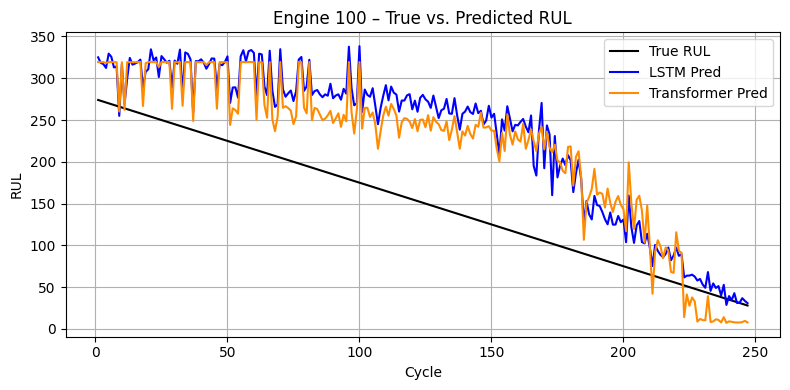

In [ ]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL',        color='black')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred',       color='blue')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred',color='darkorange')
#plt.plot(seq['cycle'], fcnn_unscaled,  label='FCNN Pred',       color='green')
#plt.plot(seq['cycle'], cnn_unscaled,   label='CNN Pred',        color='red')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.savefig('rul_predictions_TT1_6.png', dpi=300, bbox_inches='tight')
plt.show()